# COMP5318/COMP4318 Week 10: Clustering

Clustering involves partitioning the dataset into groups, called clusters. The goal is to split the dats in such a way so that the examples (data points) within each cluster are similar to each other, while the examples from different clusters are dissimilar. Clustering is an unsupervised learning task - the examples don't have class labels. 

This week we will cover two clustering algoritrhms: K-means and Gaussian Mixture Models (GMM) and hierarchical clustering, and next week we will cover hierarchical, density-based and grid-based clustering, and also clustering evaluation. 

# 1. Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
TOPIC_ID = "clustering"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", TOPIC_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)



In [2]:
# More plot functions
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)  
        

from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)    
        
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)  


def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))        

# 2. K-means 

K-Means is one of the most popular clustering algorithms; it works as follows:

- Initialize 𝑘 centroids randomly: 𝑘 distinct examples are chosen randomly from the dataset and the centroids are placed at their locations.
- Repeat until convergence (i.e. until the centroids stop moving):
    - Assign each example to the closest centroid
    - Update the centroids to be the mean of the examples that are assigned to them

Let's generate some blobs data:

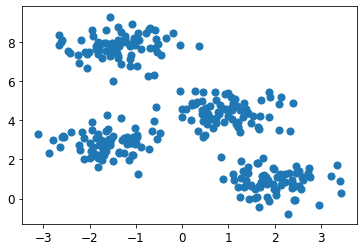

In [3]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

Looking at the data, there are 4 well-separated clusters. Now let's apply the K-means algorithm with k=4 to see if it can find the 4 clusters:

### Fit and Predict

In [4]:
from sklearn.cluster import KMeans

# select the parameter k for number of clusters
k=4
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Using <b>predict</b>, each example is assigned to one of the four clusters (0, 1, 2 or 3). We can look at the cluster label for each example and the cluster centroids, and we can visualize the result by plotting the data colored by the cluster label:

In [5]:
y_kmeans

array([1, 0, 2, 0, 1, 1, 3, 2, 0, 0, 3, 0, 2, 0, 1, 2, 2, 1, 3, 3, 1, 1,
       2, 3, 3, 2, 1, 2, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 3, 1, 2, 3, 2, 2,
       3, 3, 0, 3, 0, 1, 3, 1, 0, 1, 1, 3, 0, 3, 0, 1, 0, 2, 0, 3, 3, 3,
       0, 1, 0, 3, 2, 3, 0, 3, 3, 0, 3, 2, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2,
       0, 0, 2, 1, 0, 3, 3, 2, 1, 1, 2, 3, 0, 1, 0, 1, 2, 1, 1, 2, 0, 2,
       3, 3, 1, 0, 1, 2, 0, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 0, 3,
       3, 1, 0, 3, 3, 0, 2, 0, 0, 3, 2, 3, 2, 3, 0, 2, 0, 0, 0, 2, 0, 2,
       1, 3, 0, 3, 1, 2, 0, 2, 2, 1, 2, 3, 3, 2, 1, 2, 2, 0, 1, 2, 3, 0,
       1, 1, 2, 3, 1, 2, 3, 3, 2, 2, 2, 2, 1, 0, 2, 3, 2, 2, 3, 3, 3, 2,
       3, 0, 2, 3, 1, 3, 2, 0, 3, 0, 2, 0, 2, 3, 2, 2, 0, 3, 3, 1, 1, 2,
       0, 1, 1, 3, 1, 3, 2, 0, 0, 2, 2, 0, 2, 1, 3, 2, 1, 3, 0, 3, 1, 2,
       1, 0, 0, 0, 0, 3, 3, 0, 2, 3, 1, 2, 3, 3, 3, 1, 1, 0, 2, 2, 3, 1,
       0, 3, 2, 0, 2, 1, 1, 3, 3, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 1,
       0, 3, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 0, 3])

In [6]:
kmeans.cluster_centers_

array([[-1.37324398,  7.75368871],
       [ 1.98258281,  0.86771314],
       [ 0.94973532,  4.41906906],
       [-1.58438467,  2.83081263]])

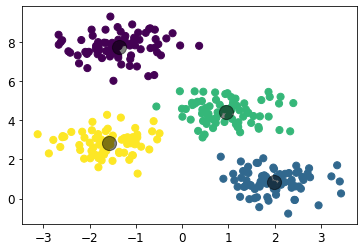

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


K-means has done a good job assigning the examples to the appropriate cluster!

We can also find the cluster of new examples - these examples will be assigned to the cluster of the closest centroid:

In [8]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([3, 1, 3, 3])

### Decision boundaries

Let's plot the decision boundaries. This gives us a _Voronoi diagram_ where each centroid is represented with an X:

Saving figure voronoi_plot


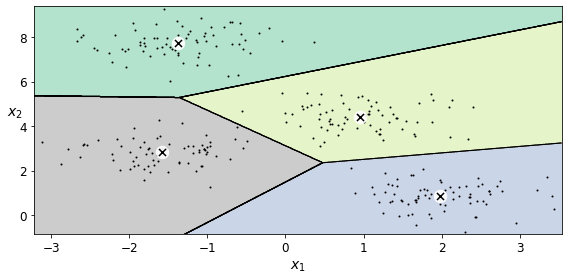

In [9]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

### K-means in action

The following example shows the K-means algorithm in action: the centroids are initialized randomly, then the examples are assigned to the closest centroid, then the centroids are updated, the examples are re-asiigned and so on for 3 iterations. As you can see, the centroids don't move much in the third iteration and the algorithm has reached a clustering that separates well the data points. 

In [10]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

Saving figure kmeans_algorithm_plot


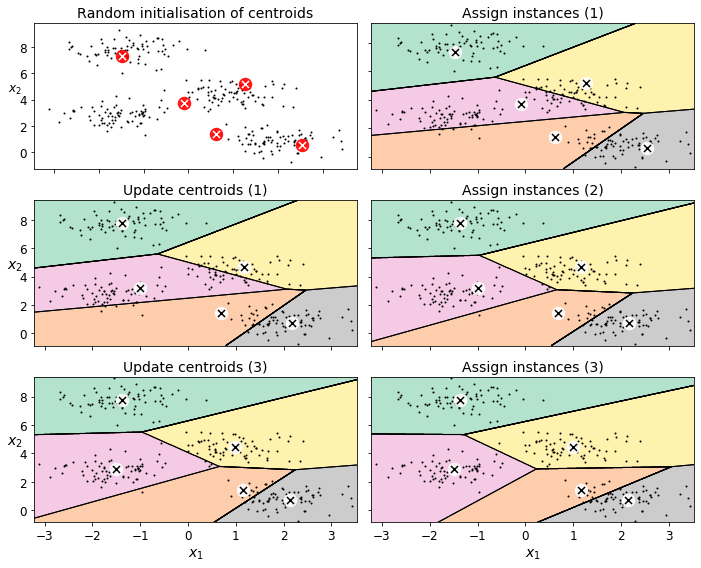

In [11]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=12, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Random initialisation of centroids", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Assign instances (1)", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)
plt.title("Update centroids (1)", fontsize=14)


plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)
plt.title("Assign instances (2)", fontsize=14)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)
plt.title("Update centroids (3)", fontsize=14)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)
plt.title("Assign instances (3)", fontsize=14)

save_fig("kmeans_algorithm_plot")
plt.show()

## 2.1. K-means - issues

### Initialization

K-means is sensitive to the centroid initialization. If we run it multiple times with different random initialization, it can converge to very different solutions. Let's use two different random seeds and visualise the decision boundaries and final centroids - they are different:

In [12]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


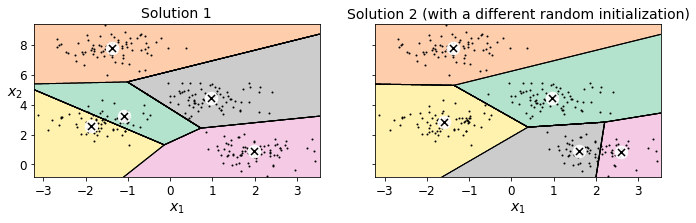

In [13]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random initialization)")

save_fig("kmeans_variability_plot")
plt.show()

### Questions:

1. How can we deal with this senitivity to initialization? Hint: Multiple runs? Can we use the  <b>n_init </b> hyperparameter? Write the code and visualise the decision boundary.
2. What methods did we study in the lecture?



### Answers:

1. We can train K-means multiple times with diferent random initialization and select the solution that minimizes the error, e.g. the sum of the squared distances between the instances and the closest centroid. The number of runs is specified by <b>n_init </b>; let's do 10 runs - see the code below. 
2. We can use other versions of K-means such as K-Means++ or bisecting K-means. To run K-Means++, set the <b> init </b> hyperparameter to <b> init='k-means++' </b>.


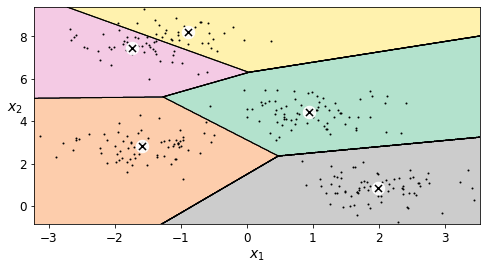

In [14]:
# 10 random initialiaztions, choose the best one
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

# plot the results
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### Number of clusters

K-means requires the number of clusters 𝑘 to be pre-specified. So far, we have set 𝑘 to 4 because it was obvious by looking at the data that there are 4 clusters. But in general, we don't know what the correct number of clusters is. K-means will always return clustreing solution, e.g. if we ask it to identify 6 clusters, it will find the best 6 clusters (as shown below) but this is not a good clustering as two of the natural clusters are split into two. Next week we will study methods for selecting the best number of clusters, such as the Elbow method and Silhouette coefficient.

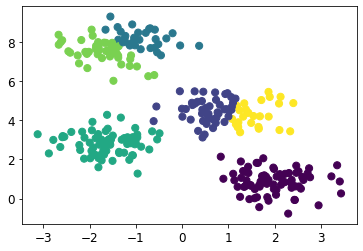

In [15]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Clusters with nonsperical shapes or complex shapes

Even if you know the right number of clusters for the given dataset, K-means might not always be able to find them. Each cluster is defined by its center, which means that each cluster has a convex shape. In addition, the boundary between clusters is exactly in the middle between the cluster centroids. As a result, K-means can only capture clusters with relatively simple shapes. The examples below show its inability to identify nonsperical clusters and clusters with complex shapes.

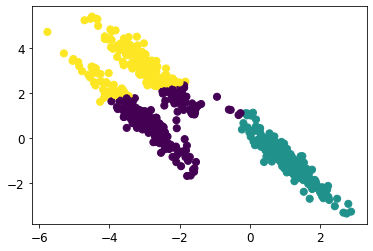

In [16]:
#Clusters with nonspherical shape

# generate some random cluster data
X1, y1 = make_blobs(random_state=170, n_samples=600)
rng = np.random.RandomState(74)

# transform the data to be stretched
transformation = rng.normal(size=(2, 2))
X1 = np.dot(X1, transformation)

# cluster the data into three clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X1)
labels = kmeans.predict(X1)

plt.scatter(X1[:, 0], X1[:, 1], c=labels, s=50, cmap='viridis');

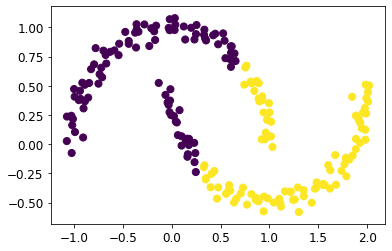

In [17]:
# clusters with complex shape
from sklearn.datasets import make_moons
X2, y2 = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X2)

plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=50, cmap='viridis');

One way to think about K-means is that it places a circle (or a sphere/hypersphere in higher dimensions) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize the clusters using the plot_kmeans function:

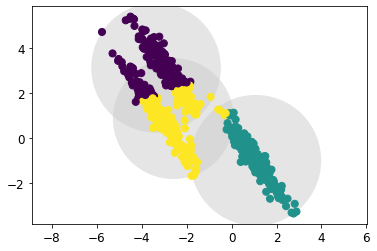

In [18]:
# Plot the clusters
plot_kmeans(kmeans, X1)

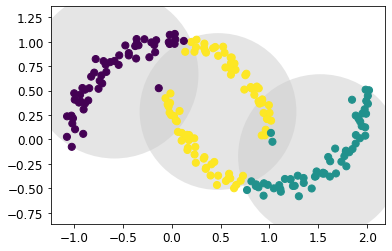

In [19]:
plot_kmeans(kmeans, X2)

Another disadvantage of K-means is that it doesn't consider the certaintly of the clustering assignment - it is more certain for the points closer to the cluster centroid and less certain for the points closer to the boundaries, but K-means doesn't use a probabilistic cluster assignment. 

# 3. Gaussian Mixture Model (GMM)

These two disadvantages of K-means — its lack of flexibility in cluster shape and lack of probabilistic cluster assignment, are addressed in the GMM clustering algorithm. It can be seen as a generalized version of K-means - it allows cluster boundaries to be ellipses rather than circles and measures the uncertainty in cluster assignment by considering the probability of each data point to belong to all clusters, rather than focusing on just the closest cluster.

GMM assumes that the instances are generates from a mixture of k Gaussian distributions whose parameters (mean values and covariance matrix) are unknown. Starting from an initial set of model parameters, it uses the Expectation Maximization algorithm to iteratively calculate the model parameters. In the E step, it calculats the probability of each instance to belong to each cluster. Then in the M step, it uses these probabilities to reculculate the model parameters. 

Let's apply GMM to a streched version of the blobs dataset and plot the result:

In [20]:
from sklearn.mixture import GaussianMixture as GMM
#gmm = GMM(n_components=4, random_state=42, max_iter=1, warm_start=True)
gmm = GMM(n_components=4, random_state=42)

# Generate stretched blobs data:
X_stretched = np.dot(X, rng.randn(2, 2))

# fit the GNN model
gmm.fit(X_stretched)

GaussianMixture(n_components=4, random_state=42)

We can loook at the parameters that the algorithm has estimated (mean values, covariances and weights of each cluster):

In [21]:
print('Cluster centers (means):\n',gmm.means_)
print('Cluster covariances:\n',gmm.covariances_)
print('Cluster weights:\n',gmm.weights_)

Cluster centers (means):
 [[ 6.38193228 10.60317015]
 [ 1.52079671  4.51185984]
 [ 2.28968749 -0.08915117]
 [ 4.90221153  5.01106158]]
Cluster covariances:
 [[[0.60999207 0.2857123 ]
  [0.2857123  0.70758172]]

 [[0.469843   0.23216315]
  [0.23216315 0.59097787]]

 [[0.46263817 0.25704027]
  [0.25704027 0.71111045]]

 [[0.49436611 0.24387942]
  [0.24387942 0.72442228]]]
Cluster weights:
 [0.2498826  0.24836039 0.24991271 0.2518443 ]


We can use the function <b> gmm_plot </b> to visualize the location and shapes of the GMM clusters by drawing elipses based on the GMM parameters we found:

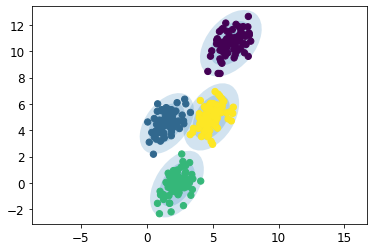

In [22]:
plot_gmm(gmm, X_stretched)

Now that we know the parameters of the clusters, we can find the cluster of new examples by using the method <b> predict </b> (hard clustering, which gives the most likily cluster) or <b> predict_prova </b> (soft clustering, which gives the membership probailities for each cluster):

In [23]:
gmm.predict(X)

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1], d

In [24]:
gmm.predict_proba(X)

array([[1.06765578e-22, 9.96279760e-01, 3.71693038e-03, 3.31006821e-06],
       [6.18172372e-10, 9.99999999e-01, 1.71453423e-29, 1.23145704e-16],
       [9.51317768e-14, 9.99999943e-01, 5.70208228e-14, 5.73718890e-08],
       ...,
       [8.61233868e-17, 9.99999999e-01, 6.78119023e-14, 6.38269066e-10],
       [2.51872722e-06, 9.99997481e-01, 1.03258492e-25, 1.73336972e-11],
       [1.17486271e-25, 1.00000000e+00, 1.83967253e-13, 8.93934145e-16]])

### Task:

Apply GMM to the moons data (which has complex shape) and visualise the clusters. Does it work well and why?


### Answer

It is better than K-means but not perfect. GMM is suitable for clusters with ellipsoidal shapes.



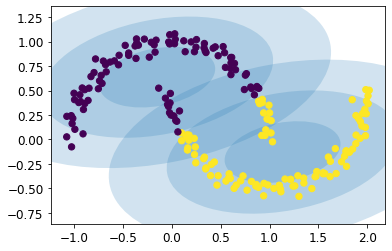

In [25]:
gmm2 = GMM(n_components=2, random_state=42)
plot_gmm(gmm2, X2)

# 4. Agglomerative hierrachical clustering

Hierrachical clustering creates a hierrachy of clusters which can be visialised using a tree-like diagram called dendrogram. There are two approaches: agglomerative and divisive; we will focus on agglomerative which is more common. Agglomerative hierrachical clustering starts with all points as individual clusters and at each step merges the closest pair of clusters iteratively until all points are in the one cluster. 

The distance between clusters can be measured in different ways, e.g. using the single link, complete link, average link or the Ward's method. These methods are implemented in sklearn and specified in the <b>linkage</b> parameter:

- <b>single</b> - merges the two clusters with the smallest <b>minimum</b> distnce between points from the two clusters
- <b>complete</b> - merges the two clusters with the smallest <b>maximum</b> distnce between points from the two clusters
- <b>average</b> - merges the two clusters with the smallest <b>average</b> distance between all their points (all combinations of points between the two clusters)
- <b>ward</b> - merges the two clusters that will result in the smallest <b>increase</b> of variance within all clusters. This is the default option.

Let's generate some 2-dimensional data and apply the agglomerative clustering. There are many possible clusterings corresponding to the different levels of the dendrogram. To obtain a specific clustering, we need to specify the number of clusters, e.g. 3. We can also obtain the cluster label for each example - 0, 1 or 2:

array([2, 1, 1, 1, 1, 2, 0, 0, 1, 0, 0, 2], dtype=int64)

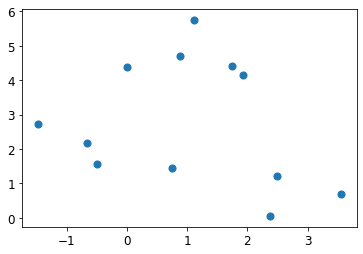

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering

# Generate some 2-dimensional data 
X, y = make_blobs(random_state=0, n_samples=12)

plt.scatter(X[:,0], X[:,1], s=50)

# Cluster the data using hierarchical agglomerative clustering
# we are looking for 3 clusters, using the default linkage function (linkage="ward")
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(X)
agg.labels_

### Drawing a dendrogram

To draw the dendrogram we need to use SciPy, it is not possible to do this with sklearn. We need to redo the clustering using the hierrachical clustering from SciPy which has a slightly different interface:

Text(0, 0.5, 'Cluster distance')

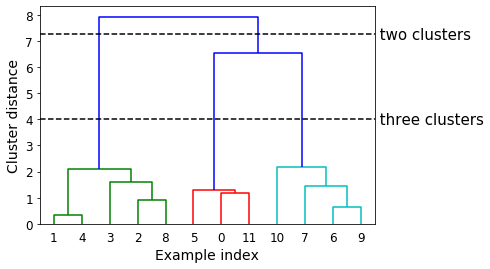

In [ ]:
# Import the dendrogram function and the Ward hierrachical clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward


# Apply the Ward hierarchical clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# when performing agglomerative clustering
linkage_array = ward(X)

# linkage_array containing the distances between clusters
# No we can plot the dentrogram using these distances
dendrogram(linkage_array)

# Add labels to the dendrogram and mark the cuts in the dendrogram that signify two or three clusters
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')

ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size': 15})
plt.xlabel("Example index")
plt.ylabel("Cluster distance")

Compare the cluster labels that we obrain from agg.labels_ with the dendrogram and note the correspondence, e.g. points 0, 5 and 11 are in the same cluster (the red one). 

Notice that the length of each dendrogram branch shows how far apart the merged clusters are. Looking at the longest branches, we can see that going from 3 to 2 clusters required merging some very far-apart points.

### Task:

Change the distance measure, e.g. use the complete link. Apply hierrachical clustering and draw the dendrogram. Compare the two dendrograms.

How many clusters are there at distance=1.7?

### Answer:

Text(0, 0.5, 'Cluster distance')

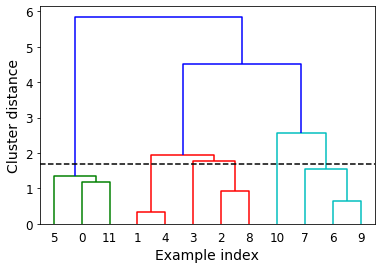

In [ ]:
# Using SciPy
from scipy.cluster.hierarchy import dendrogram, complete

#single link clustering
linkage_array = complete(X)

dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [1.7, 1.7], '--', c='k')

plt.xlabel("Example index")
plt.ylabel("Cluster distance")

There are 6 clusters at distance = 1.7: {5, 0, 11}, {1, 4}, {3}, {2, 8}, {10}, {7, 6, 9}

# 5. DBSCAN

DBSCAN is a density-based clustering algorithm. It defines clusters as continuous regios of high density. It doesn't require the number of clusters to be specified in advance, can capture clusters with complex shapes and can identify points that are not part of any cluster (noise data points).

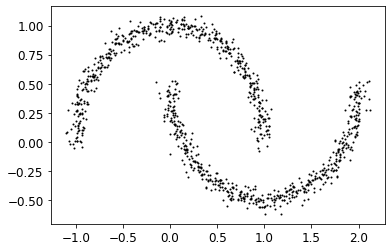

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
plot_data(X)

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

The cluster labels of all datapoints are available in the <b>labels_ </b> instance variable. A cluster label of "-1" means a noise data point. Let's look at the cluster label of the first 20 points:

In [ ]:
dbscan.labels_[:20]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4], dtype=int64)

How many clusters were found?

In [ ]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

Now we can take a closer look at the core datapoints. We can find their number and indices, and get the core points themselves:

In [ ]:
len(dbscan.core_sample_indices_)


808

In [ ]:
dbscan.core_sample_indices_[:20]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21,
       22, 23, 24], dtype=int64)

In [ ]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

Now let's plot the clustering using the <b>plot_dbscan</b> function defined in the Setup section. The noise points are shown with red crosses and the boundary points are also shown: 

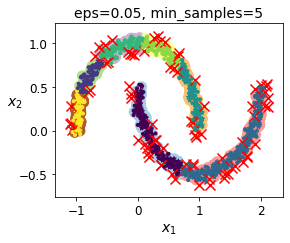

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.show()

How many clusters were found? Seven, plus many noise datapoints. Is this a good clustering?

Let's try different parameters, e.g. increase eps to 0.2 to widen the neighbourhood. We wil plot the two clusterings next to each other:

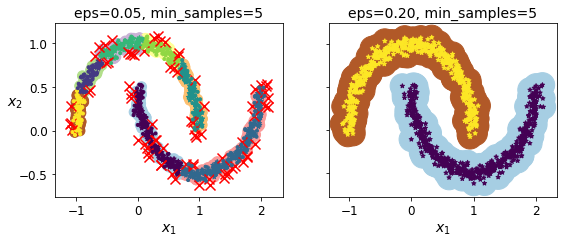

In [ ]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

The new clustering is perfect for the moons dataset!


# 6. Clustering evaluation  

So far we have evaluated the qulaity of the clustering visually. As we know from the lecture, there are measures that we can compute. Today we will see how to use the Elbow method and the Silhouette coefficient to determine the number of clusters and evaluate the qulity of different clusterings. We will use the K-means clustering algorithm. 

Let's create a dataset and do some relevant imports:

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Now let's perform K-means clustering with 𝑘=3 and 𝑘=8:

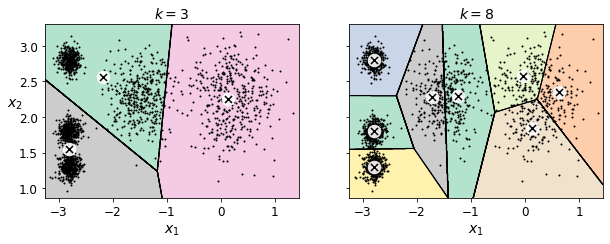

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

These two clusterings do not look well! How to find a good number of clusters 𝑘? 

### Elbow method

We can calculate the sum of the squared distances of the examples to their closest cluster centre; it is called <b>inertia</b> in sklearn. For a good clustering, would the inertia be low or high? 

In [ ]:
kmeans_k3.inertia_

653.2167190021553

In [ ]:
kmeans_k8.inertia_

119.1198341610288

A low inertia is better - well done! 

However, as we increase 𝑘, the values of the inertia decreases. This is because the more clusters there are, the closer each example will be to its closest centroid, and therefore the lower the inertia will be. 

So we cannot simply choose the 𝑘 which  minimizes the inertia. But we can plot the inertia as a function of 𝑘 and analyze the resulting curve:

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

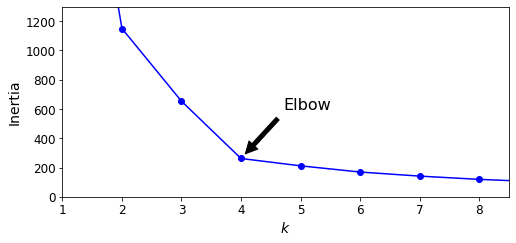

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

The elbow method is a heuristic method.As you can see, there is an "elbow" at 𝑘=4. After this value, the decrease in inertia is very slow, the curve almost flattens. Hence, having more than 4 clusters will not help much. 

Based on it, we can choose 𝑘=4. For our dataset this means that the two blobs in the lower left part will be considered as a single cluster, so it is not a perfect but still a pretty good choice.


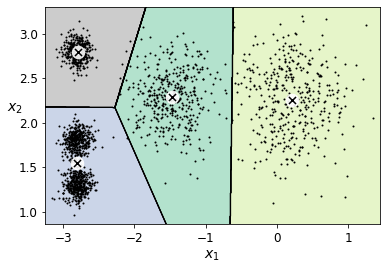

In [ ]:
k = 4
plot_decision_boundaries(kmeans_per_k[k-1], X)
plt.show()

### Silhouette coefficient

Another method is to calculate the <b>silhouette score</b>, which is the mean silhouette coefficient over all the examples. An example's silhouette coefficient is equal to (𝑏−𝑎)/max(𝑎,𝑏) where 𝑎 is the mean distance to the other examples in the same cluster (it is the <b>mean intra-cluster distance</b>), and 𝑏 is the <b>mean nearest-cluster distance</b>, that is the mean distance to the examples of the next closest cluster (defined as the one that minimizes 𝑏, excluding the example's own cluster). 


The silhouette coefficient varies between -1 and +1. A value close to +1 means that the example is well inside its own cluster and far from other clusters, a value close to 0 means that it is close to a cluster boundary, and finally a value close to -1 means that the example may have been assigned to the wrong cluster.

To calculate the silhouette score, we can use the silhouette_score() function, giving it all examples in the dataset and the cluster labels they were assigned to:

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans_k3.labels_)

0.5723900247411775

Let's plot the silhouette score as a function of 𝑘:

Saving figure silhouette_score_vs_k_plot


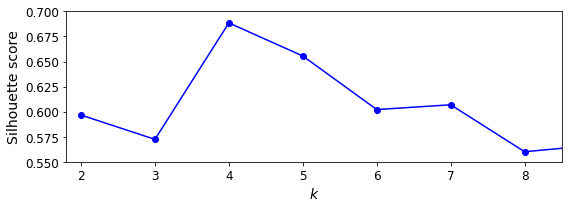

In [ ]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one - although it confirms that 𝑘=4 is a very good choice, it also underlines the fact that 𝑘=5 is quite good as well.

An even more informative visualization is given when you plot every example's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a <b>silhouette diagram</b>:


Saving figure silhouette_analysis_plot


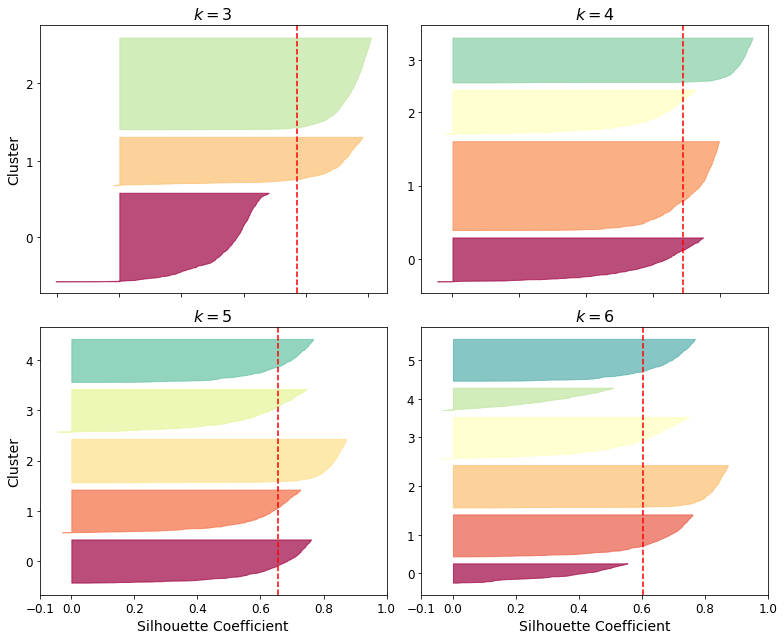

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

The red dashed vertical lines represent the silhouette score for each k. 

When most of the examples in a cluster have a lower coefficient than this score (i.e. they are on the left side of the line), then the cluster is bad since this means that its examples are too close to other clusters. We can see that for k = 3 and k = 6, we get bad clusters. But when k = 4 or k = 5, the clusters look pretty good: most examples extend beyond the dashed line, to the right and closer to 1.0. 

Comparing the clusterinngs for k=4 and k=5: 
- When k = 4, the cluster at index 1 (the third from the top) is rather big
- When k = 5, all clusters have similar sizes
- So even though the overall silhouette score for k = 4 is slightly greater than for k = 5, it seems like a good idea to use k = 5 to get clusters of similar sizes

For data with higher dimensionality than 2-3, it is not possible to analyse the silhouette coefficient visually in this way, but we can still calculate its value. 

## Summary

In [34]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
gmm = GMM(n_components=k)
gmm.fit(X)
gmm.predict_proba(X)

agg = AgglomerativeClustering(n_clusters=3)
agg.fit(X)

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

### Acknowledgements

This tutorial is based on:

Aurelien Geron (2022). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly.

Jake VanderPlas (2016). Python Data Science Handbook, O'Reilly.